In [304]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from rosbags.highlevel import AnyReader

import numpy as np
import seaborn as sns

import os

## Functions for reading ROS2 bags

In [305]:

def get_pose_data(bag_path, topic_name):
    poses_data = {
        'timestamp': [],
        'time_sec': [],
        'position_x': [],
        'position_y': [],
        'position_z': [],
        'orientation_x': [],
        'orientation_y': [],
        'orientation_z': [],
        'orientation_w': []
    }

    with AnyReader([bag_path]) as reader:
        # Print bag info
        print(f"Bag duration: {reader.duration / 1e9:.2f} seconds")
        print(f"Message count: {reader.message_count}")

        connection = [x for x in reader.connections if x.topic == topic_name]

        # Read messages
        for connection, timestamp, rawdata in reader.messages(connections=connection):
            msg = reader.deserialize(rawdata, connection.msgtype)

            # Extract pose data
            poses_data['timestamp'].append(timestamp)
            poses_data['time_sec'].append(timestamp / 1e9)

            poses_data['position_x'].append(msg.position.x)
            poses_data['position_y'].append(msg.position.y)
            poses_data['position_z'].append(msg.position.z)

            poses_data['orientation_x'].append(msg.orientation.x)
            poses_data['orientation_y'].append(msg.orientation.y)
            poses_data['orientation_z'].append(msg.orientation.z)
            poses_data['orientation_w'].append(msg.orientation.w)

    poses_data = pd.DataFrame(poses_data)
    
    # clean up time_sec
    # poses_data['time_sec'] = poses_data['time_sec'] - poses_data['time_sec'].min()
    return poses_data

def get_cmd_vel_data(bag_path, topic_name):
    cmd_vel_data = {
        'timestamp': [],
        'time_sec': [],
        'linear_x': [],
        'angular_z': []
    }

    with AnyReader([bag_path]) as reader:
        # Print bag info
        print(f"Bag duration: {reader.duration / 1e9:.2f} seconds")
        print(f"Message count: {reader.message_count}")

        connection = [x for x in reader.connections if x.topic == topic_name]

        # Read messages
        for connection, timestamp, rawdata in reader.messages(connections=connection):
            msg = reader.deserialize(rawdata, connection.msgtype)

            # Extract pose data
            cmd_vel_data['timestamp'].append(timestamp)
            cmd_vel_data['time_sec'].append(timestamp / 1e9)
            cmd_vel_data['linear_x'].append(msg.linear.x)
            cmd_vel_data['angular_z'].append(msg.angular.z)

    cmd_vel_data = pd.DataFrame(cmd_vel_data)

    # clean up time_sec
    # cmd_vel_data['time_sec'] = cmd_vel_data['time_sec'] - cmd_vel_data['time_sec'].min()

    return cmd_vel_data

def get_force_data(bag_path, topic_name):
    force_data = {
        'timestamp': [],
        'time_sec': [],
        'data': []
    }
    with AnyReader([bag_path]) as reader:
        # Print bag info
        print(f"Bag duration: {reader.duration / 1e9:.2f} seconds")
        print(f"Message count: {reader.message_count}")

        connection = [x for x in reader.connections if x.topic == topic_name]

        # Read messages
        for connection, timestamp, rawdata in reader.messages(connections=connection):
            msg = reader.deserialize(rawdata, connection.msgtype)
            force_data['timestamp'].append(timestamp)
            force_data['time_sec'].append(timestamp / 1e9)
            force_data['data'].append(msg.data)

    force_data = pd.DataFrame(force_data)

    # clean up time_sec
    # force_data['time_sec'] = force_data['time_sec'] - force_data['time_sec'].min()

    return force_data

def get_payload_pose(bag_path, topic_name):
    payload_poses = {
        'timestamp': [],
        'time_sec': [],
        'position_x': [],
        'position_y': [],
        'position_z': [],
        'orientation_x': [],
        'orientation_y': [],
        'orientation_z': [],
        'orientation_w': [],
    }

    with AnyReader([bag_path]) as reader:
        # Print bag info
        print(f"Bag duration: {reader.duration / 1e9:.2f} seconds")
        print(f"Message count: {reader.message_count}")

        connection = [x for x in reader.connections if x.topic == topic_name]

        # Read messages
        for connection, timestamp, rawdata in reader.messages(connections=connection):
            msg = reader.deserialize(rawdata, connection.msgtype)

            for t in msg.transforms:
                if t.child_frame_id == 'payload':        
                    # print(t)
                    payload_poses['timestamp'].append(timestamp)
                    payload_poses['time_sec'].append(timestamp / 1e9)

                    payload_poses['position_x'].append(t.transform.translation.x)
                    payload_poses['position_y'].append(t.transform.translation.y)
                    payload_poses['position_z'].append(t.transform.translation.z)

                    payload_poses['orientation_x'].append(t.transform.rotation.x)
                    payload_poses['orientation_y'].append(t.transform.rotation.y)
                    payload_poses['orientation_z'].append(t.transform.rotation.z)
                    payload_poses['orientation_w'].append(t.transform.rotation.w)

    payload_poses = pd.DataFrame(payload_poses)

    return payload_poses


## Functions for plotting

In [306]:
from matplotlib.lines import Line2D
def plot_trajectory(data1, data2, haxis, vaxis, robot_name):
    plt.plot(
        data1,
        data2,
        '-r'
    )
    plt.grid(True)
    plt.xlabel(haxis)
    plt.ylabel(vaxis)
    plt.title(f'Trajectory over time for {robot_name}')
    plt.show()


def plot_displacements_over_time(timestamps, monica_poses, ross_poses):
    initial_displacement = 0.86  # cm
    displacements = np.abs(
        monica_poses - ross_poses
    ) - initial_displacement

    plt.plot(
        timestamps,
        displacements,
        '-r'
    )
    plt.grid(True)
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title('Displacement over time for monica and ross')
    plt.show()


def plot_forces(timestamps, monica_force_data, ross_force_data):
    plt.plot(
        timestamps,
        monica_force_data,
        '-r'
    )
    plt.plot(
        timestamps,
        ross_force_data,
        '-b'
    )
    plt.legend(['monica', 'ross'])
    plt.grid(True)
    plt.xlabel('t')
    plt.ylabel('force (N)')
    plt.title('Force readings over time')
    plt.show()


def plot_force_data(timestamps, force_data):
    plt.plot(
        timestamps,
        force_data,
        '-b'
    )
    plt.grid(True)
    plt.xlabel('t')
    plt.ylabel('force (N)')
    plt.title('Force readings over time')
    plt.show()


def plot_traj_and_force(
    trajectories, forces,
    fig_size=(18, 8),
    ross_color='blue',
    monica_color='red',
    payload_color='green'):
    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=fig_size,
    )

    # plot trajectories
    axes[0].plot(
        trajectories['act_mon_x'],
        trajectories['act_mon_y'],
        label='Monica\'s actual trajectory',
        color=monica_color,
        linestyle='-',
        markersize=6
    )
    axes[0].plot(
        trajectories['act_ross_x'],
        trajectories['act_ross_y'],
        label='Ross\'s actual trajectory',
        color=ross_color,
        linestyle='-',
        markersize=6
    )
    axes[0].plot(
        trajectories['act_payload_x'],
        trajectories['act_payload_y'],
        label='Payload\'s actual trajectory',
        color=payload_color,
        linestyle='-',
        markersize=6
    )
    axes[0].set_xlabel('x (m)')
    axes[0].set_ylabel('y (m)')
    axes[0].set_title('Actual Trajectories')
    axes[0].legend()
    axes[0].grid(True)
    
    # plot forces
    axes[1].plot(
        # TODO: change this to x
        forces['ros_time_sec'],
        forces['force_monica'],
        label='Monica\'s force readings',
        color=monica_color,
        linestyle='-',
        markersize=6
    )
    axes[1].plot(
        forces['ros_time_sec'],
        forces['force_ross'],
        label='Ross\'s force readings',
        color=ross_color,
        linestyle='-',
        markersize=6
    )
    axes[1].set_xlabel('t')
    axes[1].set_ylabel('F (N)')
    axes[1].set_title('Forces over time')
    axes[1].legend()
    axes[1].grid(True)

    fig.tight_layout()


def create_box_plot(distance_df, fig_size=(18, 6), fontsize=16):
    """
    @param distance_df: a DataFrame of the distances traveled for each
        trial.
    """
    plt.figure(figsize=fig_size)
    sns.set_theme(
        style='white',
        font="Times New Roman"
    )
    ax = sns.boxplot(
        data=distance_df, x="experiment_type", y="distance_traveled",
        notch=True,
        showcaps=False,
        showmeans=True,
        flierprops={"marker": "x"},
        medianprops={
            "color": "orange",
            "linewidth": 1.5
        },
        boxprops={
            "facecolor": "white",
            "edgecolor": "black",
            "linewidth": 1.5,
            "alpha": 0.8
        },
        meanprops={
            "marker": "o",
            "markerfacecolor": "black",
            "markeredgecolor": "black",
            "markersize": 8
        },
    )

    plt.title("Distance Traveled by Experiment Type",
            fontsize=fontsize, fontweight='bold', pad=20)
    plt.xlabel("Experiment Type", fontsize=fontsize, fontweight='semibold')
    plt.ylabel("Distance Traveled (m)", fontsize=fontsize, fontweight='semibold')

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

    plt.tight_layout()
    plt.show()
    

## Other helper functions

In [307]:
def zoom(time_series, start, end):
    return time_series[
        (time_series['time_sec'] >= start) &
        (time_series['time_sec'] <= end)
    ]


def payload_distance_estimator(trial_df):
    # Get start and end timestamps
    non_zero_cmd_vel = trial_df[trial_df['ross_cmd_vel_linear_x'] != 0]
    start_timestamp = non_zero_cmd_vel['ros_time_sec'].iloc[0]
    end_timestamp = non_zero_cmd_vel['ros_time_sec'].iloc[-1]

    # Filter the trial_csv based on the start and end timestamps
    filtered_data = trial_df[(trial_df['ros_time_sec'] >= start_timestamp) &
                             (trial_df['ros_time_sec'] <= end_timestamp)]

    # Calculate the Euclidean distance for the payload
    payload_distances = np.sqrt(
        np.diff(filtered_data['act_payload_x'])**2 +
        np.diff(filtered_data['act_payload_y'])**2
    )
    total_payload_distance = np.sum(payload_distances)

    return total_payload_distance


def clean_data(time_series: pd.DataFrame, time_col='time_sec'):
    # fix time_sec column
    time_series[time_col] = time_series[time_col] - \
        time_series[time_col].min()

    # fill in null values
    # time_series = time_series.set_index('time_sec')
    # time_series = time_series.interpolate(method='time').reset_index()
    time_series = time_series.interpolate(method='linear')
    time_series = time_series.fillna(method='bfill')

    return time_series



def get_time_series_data(path, data_type, time_col='time_sec'):
    # fetch the data from the ros2 bag

    if data_type == 'poses':
        ross_data = get_pose_data(path, '/world_ross_pose')
        monica_data = get_pose_data(path, '/world_monica_pose')

    elif data_type == 'force':
        ross_data = get_force_data(path, '/ross/force')
        monica_data = get_force_data(path, '/monica/force')

    elif data_type == 'csv_force':
        ross_data = pd.read_csv(path + 'ross_admittance_data.csv')
        monica_data = pd.read_csv(path + 'monica_admittance_data.csv')

    else:
        ross_data = get_cmd_vel_data(path, '/ross/cmd_vel')
        monica_data = get_cmd_vel_data(path, '/monica/cmd_vel')

    # save everything to a single dataframe
    time_series_df = pd.merge(
        monica_data,
        ross_data,
        on=time_col,
        how='outer',
        suffixes=('_monica', '_ross')
    ).sort_values(time_col).reset_index(drop=True)

    time_series_df = clean_data(time_series_df, time_col=time_col)

    return time_series_df


def generate_box_plot_data(p_trials_path, a_trials_path, dp_trials_path) -> pd.DataFrame:
    """
    Generate box plot data by reading trajectory data from trial directories.
    
    @param p_trials_path: path to P experiment trials
    @param a_trials_path: path to A experiment trials  
    @param dp_trials_path: path to DP experiment trials
    @return: DataFrame with columns ['experiment_type', 'distance_traveled']
    """
    results = {
        'experiment_type': [],
        'distance_traveled': []
    }

    # Process each experiment type
    experiment_configs = [
        (p_trials_path, 'Position control'),
        (a_trials_path, 'Admittance control'),
        (dp_trials_path, 'Dynamic admittance control')
    ]

    for trials_path, experiment_type in experiment_configs:
        if not os.path.exists(trials_path):
            print(
                f"Warning: Path {trials_path} does not exist, skipping {experiment_type} trials")
            continue

        for trial in os.listdir(trials_path):
            trajectory_df = pd.read_csv(trials_path + trial + "/trajectory_data.csv")
            distance = payload_distance_estimator(trajectory_df)
            results['experiment_type'].append(experiment_type)
            results['distance_traveled'].append(distance)

    return pd.DataFrame(results)

## Old Trials

In [308]:
bag_path = Path('../../bags/08-11_admittance/trial_2')
# bag_path = Path('../../bags/exp_1')

time_series = get_time_series_data(bag_path, 'poses')

# time_series.info()

payload_poses = get_payload_pose(bag_path, '/tf')
payload_poses = clean_data(payload_poses)

Bag duration: 35.51 seconds
Message count: 80001
Bag duration: 35.51 seconds
Message count: 80001
Bag duration: 35.51 seconds
Message count: 80001


/tmp/ipykernel_12546/2265570015.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series = time_series.fillna(method='bfill')
/tmp/ipykernel_12546/2265570015.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series = time_series.fillna(method='bfill')


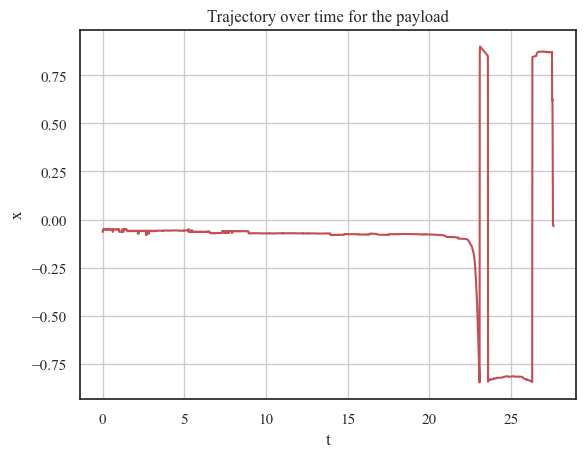

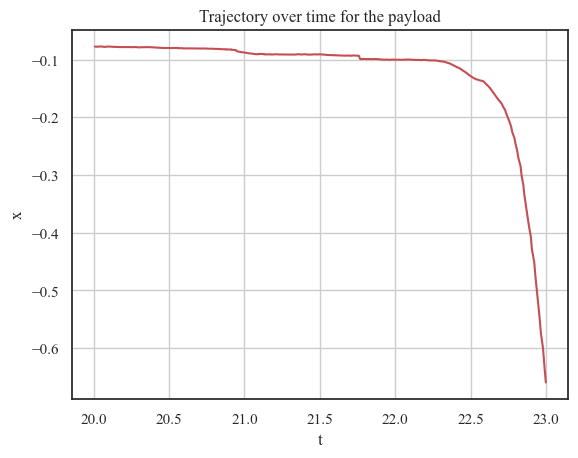

In [309]:
plot_trajectory(payload_poses['time_sec'].to_numpy(),
                payload_poses['orientation_x'].to_numpy(), 't', 'x', 'the payload')

zoomed_in_df = zoom(payload_poses, 20.0, 23.0)

plot_trajectory(
    zoomed_in_df['time_sec'].to_numpy(),
    zoomed_in_df['orientation_x'].to_numpy(),
    't',
    'x',
    'the payload'
)

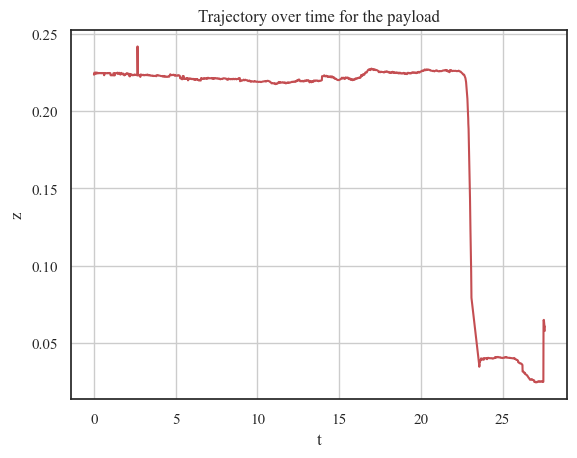

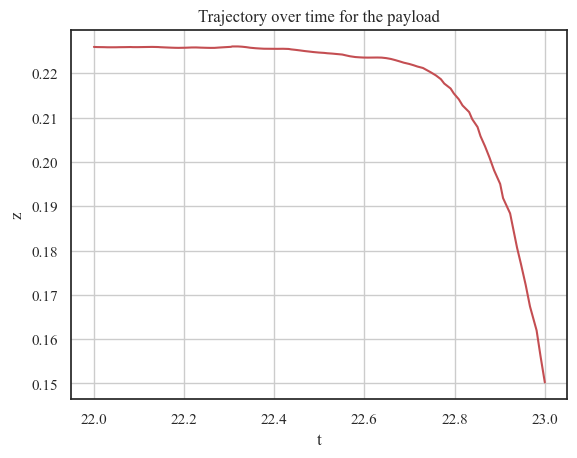

In [310]:
plot_trajectory(payload_poses['time_sec'].to_numpy(), payload_poses['position_z'].to_numpy(), 't', 'z', 'the payload')

zoomed_in_df = zoom(payload_poses, 22.0, 23.0)

plot_trajectory(
    zoomed_in_df['time_sec'].to_numpy(),
    zoomed_in_df['position_z'].to_numpy(),
    't',
    'z',
    'the payload'
)

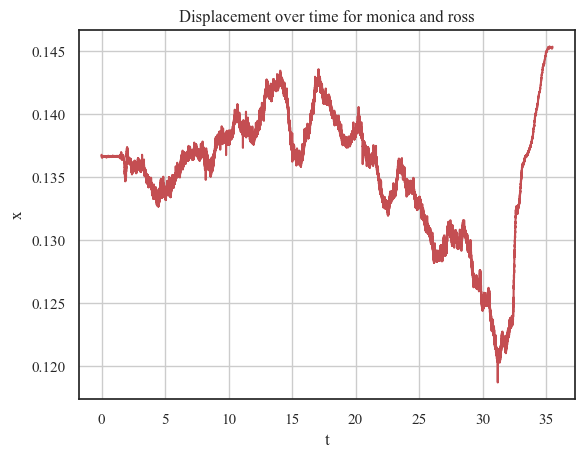

In [311]:
plot_displacements_over_time(
    time_series['time_sec'].to_numpy(),
    time_series['position_x_monica'].to_numpy(),
    time_series['position_x_ross'].to_numpy()
)

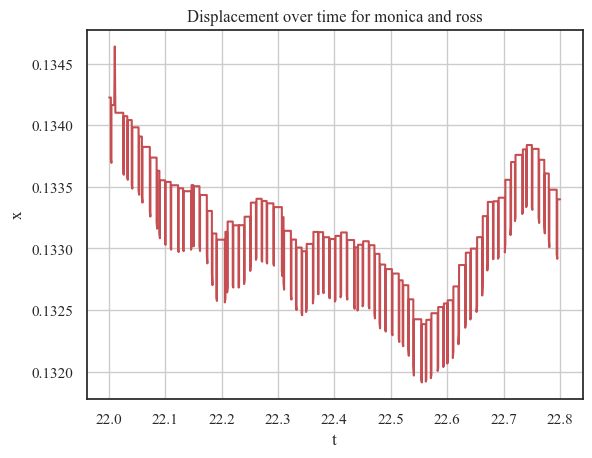

In [312]:
zoomed_in_df = zoom(time_series, 22.0, 22.8)

plot_displacements_over_time(
    zoomed_in_df['time_sec'].to_numpy(),
    zoomed_in_df['position_x_monica'].to_numpy(),
    zoomed_in_df['position_x_ross'].to_numpy()
)

In [313]:
force_time_series = get_time_series_data(bag_path, 'force')

force_time_series.info()

Bag duration: 35.51 seconds
Message count: 80001
Bag duration: 35.51 seconds
Message count: 80001
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2367 entries, 0 to 2366
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   timestamp_monica  2367 non-null   float64
 1   time_sec          2367 non-null   float64
 2   data_monica       2367 non-null   float64
 3   timestamp_ross    2367 non-null   float64
 4   data_ross         2367 non-null   float64
dtypes: float64(5)
memory usage: 92.6 KB


/tmp/ipykernel_12546/2265570015.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series = time_series.fillna(method='bfill')


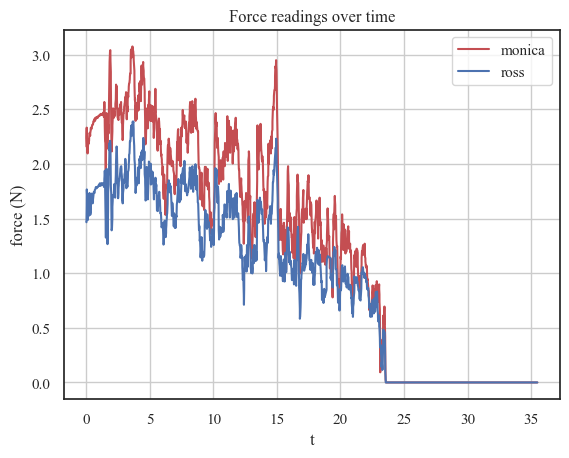

1.2209132611751556
0.9226876387162505


In [314]:
plot_forces(force_time_series['time_sec'].to_numpy(), force_time_series['data_monica'].to_numpy(), force_time_series['data_ross'].to_numpy())

print(force_time_series['data_monica'].mean())
print(force_time_series['data_ross'].mean())

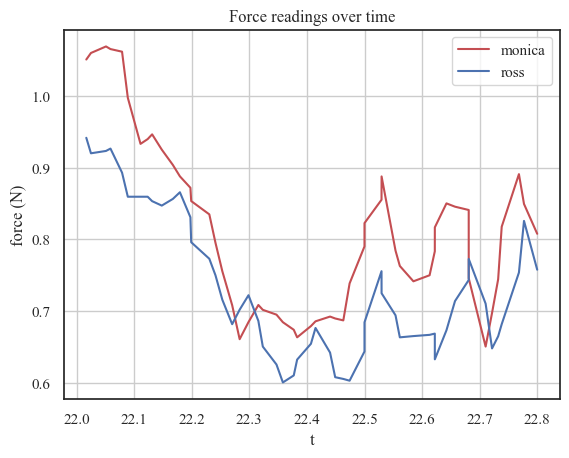

In [315]:
zoomed_in_df = zoom(force_time_series, 22.0, 22.8)

plot_forces(zoomed_in_df['time_sec'].to_numpy(),
            zoomed_in_df['data_monica'].to_numpy(), 
            zoomed_in_df['data_ross'].to_numpy())

In [316]:
# Determining distance traveled
monica_dist = time_series[
    (time_series['time_sec'] >= 33.4) &
    (time_series['time_sec'] <= 33.41)
]['position_x_monica'].mean() - time_series['position_x_monica'].min()

# Determining distance traveled
ross_dist = time_series[
    (time_series['time_sec'] >= 33.4) &
    (time_series['time_sec'] <= 33.41)
]['position_x_monica'].mean() - time_series['position_x_monica'].min()

print(f'(Twist started)\nMonica distance traveled: {monica_dist} \nRoss distance traveled: {ross_dist}')

(Twist started)
Monica distance traveled: 3.0486853182315827 
Ross distance traveled: 3.0486853182315827


In [317]:
# Determining distance traveled
monica_dist = time_series[
    (time_series['time_sec'] >= 33.7) &
    (time_series['time_sec'] <= 33.71)
]['position_x_monica'].mean() - time_series['position_x_monica'].min()

# Determining distance traveled
ross_dist = time_series[
    (time_series['time_sec'] >= 33.7) &
    (time_series['time_sec'] <= 33.71)
]['position_x_monica'].mean() - time_series['position_x_monica'].min()

print(
    f'(Dropped box)\nMonica distance traveled: {monica_dist} \nRoss distance traveled: {ross_dist}')

(Dropped box)
Monica distance traveled: 3.0540800392627716 
Ross distance traveled: 3.0540800392627716


## Analyzing CSV data

In [318]:
csv_path = '../../data/08-25_dp_experiment/08-25_dp_right_trial_01/'

traj_df = pd.read_csv(csv_path + 'trajectory_data.csv')

traj_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1501 entries, 0 to 1500
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   des_ross_x                1501 non-null   float64
 1   des_ross_y                1501 non-null   float64
 2   des_ross_theta            1501 non-null   float64
 3   des_mon_x                 1501 non-null   float64
 4   des_mon_y                 1501 non-null   float64
 5   des_mon_theta             1501 non-null   float64
 6   act_ross_x                1501 non-null   float64
 7   act_ross_y                1501 non-null   float64
 8   act_ross_theta            1501 non-null   float64
 9   act_mon_x                 1501 non-null   float64
 10  act_mon_y                 1501 non-null   float64
 11  act_mon_theta             1501 non-null   float64
 12  act_payload_x             1501 non-null   float64
 13  act_payload_y             1501 non-null   float64
 14  act_payl

In [319]:
forces_df = get_time_series_data(
    csv_path, 'csv_force', time_col='ros_time_sec')

forces_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54059 entries, 0 to 54058
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   t_p_x_monica        54059 non-null  float64
 1   t_p_y_monica        54059 non-null  float64
 2   t_p_z_monica        54059 non-null  float64
 3   t_w_monica          54059 non-null  float64
 4   t_x_monica          54059 non-null  float64
 5   t_y_monica          54059 non-null  float64
 6   t_z_monica          54059 non-null  float64
 7   v_p_x_monica        54059 non-null  float64
 8   v_p_y_monica        54059 non-null  float64
 9   v_p_z_monica        54059 non-null  float64
 10  v_w_monica          54059 non-null  float64
 11  v_x_monica          54059 non-null  float64
 12  v_y_monica          54059 non-null  float64
 13  v_z_monica          54059 non-null  float64
 14  force_monica        54059 non-null  float64
 15  stiffness_monica    54059 non-null  float64
 16  ros_

/tmp/ipykernel_12546/2265570015.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series = time_series.fillna(method='bfill')


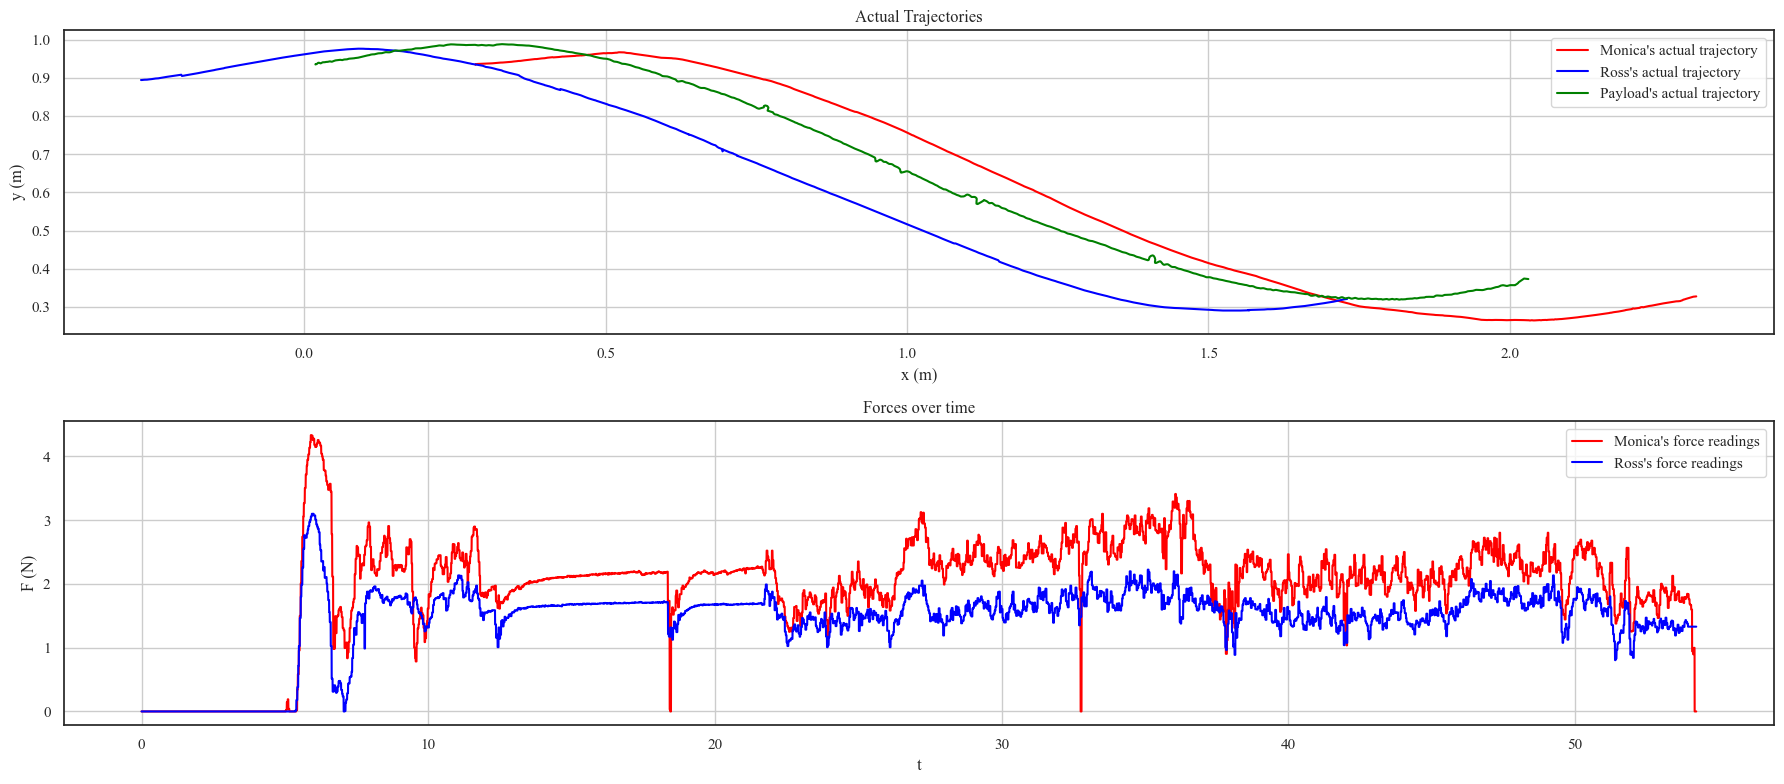

In [320]:
plot_traj_and_force(traj_df, forces_df)

## Box with Notches Plot

In [321]:
distances_df = generate_box_plot_data(
    '../../data/08-25_p_experiments/',
    '../../data/08-25_a_experiments/',
    '../../data/08-25_dp_experiment/'
)

distances_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   experiment_type    65 non-null     object 
 1   distance_traveled  65 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


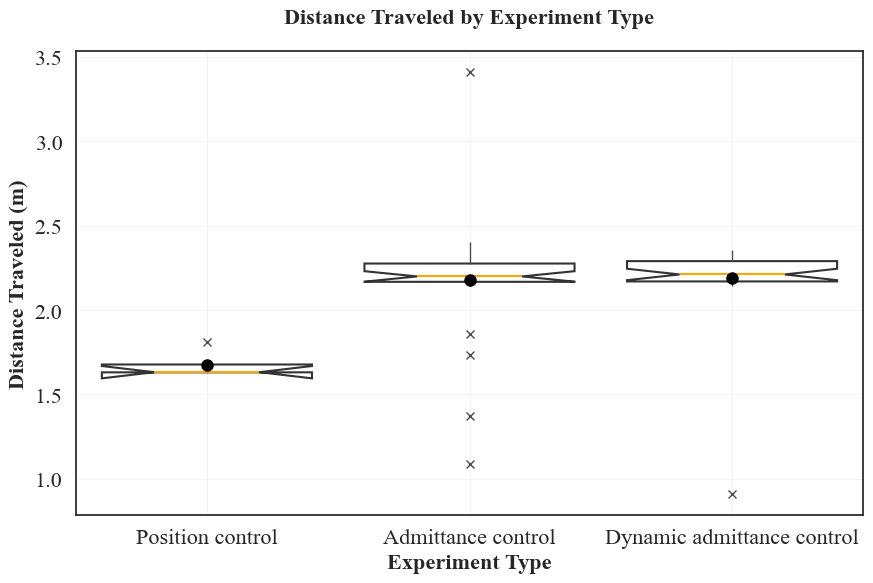

In [322]:
create_box_plot(
    distances_df,
    fig_size=(9, 6)    
)